I recently came across [a pretty cool paper by Zenitani and Umeda named "On the Boris solver in particle-in-cell simulation"](https://arxiv.org/abs/1809.04378). There are many splendid descriptions of the Boris solver on the Internet, so while I would rather not duplicate them, here's a brief overview. In PIC simulations, the Boris solver (or pusher) is the usual algorithm of choice for moving and accelerating particles in given electric and magnetic fields.

You may wonder, since the equations of motion are ordinary differential equations, what's wrong with using the usual Runge-Kutta 4 solver? As it turns out, that one has a pretty major flaw. It has great accuracy for short term calculations, but over time your particle's motion will lose energy. This is a deal breaker for periodic motion, and simulations of, for example, plasma waves need to conserve that energy to provide accurate results.

Boris came up with his solver in the 1950's, and in a single sentence: the algorithm splits the acceleration via electric field into two parts and sticks a rotation about the magnetic field between them. This turns out to conserve energy and will probably come up again on this blog as I read more about symplexicity. 
<!-- TEASER_END -->

However, there's a catch. There's a single basic and dense textbook for particle simulation, called "Plasma Physics via Computer Simulation" by Birdsall and Langdon. It has been referenced in most PIC papers I've read. The Boris solver as described by this PIC bible involves a vector quantity (following the authors we'll call this part of the `Boris-B` algorithm):
    
$$\vec{t} = \frac{\theta}{2} \vec{b} \tag{Boris-B}$$
    
$\vec{b}$ being the unit vector in the direction of the magnetic field $\vec{B}$ and $\theta \sim dt |\vec{B}|$. However, what Boris originally had in his derivation was (the `Boris-A` algorithm):

$$\vec{t} = \tan{\frac{\theta}{2}} \vec{b} \tag{Boris-A}$$

And there's a subtle difference there! Well, it's subtle if you have $\frac{\theta}{2} << 1$ and quickly stops being subtle if you

1. have large $\theta$, which you probably shouldn't as it's proportional to the timestep
2. care about the performance of your pusher, which you probably should

The version in B&L's book is a simplification (admittedly one that B&L pointed out was being made) that incorporates a slight error in the calculation, but turns out to be a bit faster (tangents were quite expensive to calculate back then). For a very simple comparison of the two:

In [1]:
from math import tan
theta = 0.1

just_division = %timeit -o theta/2

54.7 ns ± 1.71 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [2]:
tangent_division = %timeit -o tan(theta/2)

112 ns ± 1.69 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [3]:
(tangent_division.average) / just_division.average

2.0398646137513388

And that's on a modern CPU with a modern `math` library in a modern language! At the time of writing of B&L's book, this was indeed something people found valuable to optimize out of their code.

What the authors of this paper did was take a few more steps of the calculation in the entire `Boris-A` algorithm and rewrite them into the `Boris-C` version, which turns out to be
* just as accurate as `Boris-A` (see the plots in the paper for some really neat results)
* "only 25% slower than the Boris-B solver"
* "faster than the Boris-A solver" (where Boris-A was 46% slower than Boris-B)

This is neat, so I figured we could maybe do this in Python really quickly to show how it works.

Let's start with the classic version. We'll first include a couple of helpers:

In [21]:
from scipy.constants import m_e, e, c

In [70]:
import numpy as np

charge = -e
mass = m_e
lightspeed = c

# charge = 1
# mass = 1
# lightspeed = 1


def epsilon(electric_field, timestep):
    return charge * timestep / (2*mass) * electric_field 

def gamma_from_velocity(velocity):
    return np.sqrt(1 - np.sum((velocity / lightspeed)**2))

def gamma_from_u(u):
    return np.sqrt(1+np.sum((u/lightspeed)**2))

We can now proceed to implement the various versions of the Boris solver. I'm mostly just going through the paper and turning the equations into code, nothing crazy.`u_t_minus_half` is the velocity at time $t-\Delta t /2$, as the Boris solver takes particle velocities as **shifted in time**: with a timestep $\Delta t$, you get positions at $t = 0, \Delta t, 2 \Delta t ...$, while your velocities are defined at times $t = -\Delta t / 2, + \Delta t / 2, 3 \Delta t / 2...$

In [71]:
def BorisA(position, u_t_minus_half, electric_field, magnetic_field, timestep):
    # Equations 3, 6, 7a, 8, 9, 5
    uminus = u_t_minus_half + epsilon(electric_field, timestep)  # Eq. 3
    magfield_norm = np.linalg.norm(magnetic_field)
    theta = charge * timestep / mass / gamma_from_u(uminus) * magfield_norm  # Eq. 6
        
    b = magnetic_field / magfield_norm
    
    t = np.tan(theta/2) * b # Eq. 7a
    
    uprime = uminus + np.cross(uminus, t)  # Eq. 8
    uplus = uminus + 2/(1+(t**2).sum()) * np.cross(uprime, t)  # Eq. 9
    u_t_plus_half = uplus + epsilon(electric_field, timestep) # Eq. 5
    new_position = u_t_plus_half / gamma_from_u(u_t_plus_half) * timestep + position # Eq. 1
    return new_position, u_t_plus_half 
    
def BorisC(position, u_t_minus_half, electric_field, magnetic_field, timestep):
    # 3, 6, 11, 12, 5
    uminus = u_t_minus_half + epsilon(electric_field, timestep)  # Eq. 3
    magfield_norm = np.linalg.norm(magnetic_field)
    theta = charge * timestep / mass / gamma_from_u(uminus) * magfield_norm  # Eq. 6
    
    b = magnetic_field / magfield_norm
    
    u_parallel_minus = np.dot(uminus, b) * b # Eq. 11
    uplus = u_parallel_minus + (uminus - u_parallel_minus) * np.cos(theta) + np.cross(uminus, b) * np.sin(theta) # Eq. 12
    u_t_plus_half = uplus + epsilon(electric_field, timestep) # Eq. 5
    new_position = u_t_plus_half / gamma_from_u(u_t_plus_half) * timestep + position # Eq. 1
    return new_position, u_t_plus_half 

We can now start implementing the authors' test cases as seen in the paper. We'll first define a helper plotting function:

In [72]:
def plot(r, v, trajectory_format = ".:", timeseries_format = ".--"):
    x, y, z = r.T
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes[0,0].plot(x, timeseries_format, label="x")
    axes[0,0].plot(y, timeseries_format, label="y")
    axes[0,0].plot(z, timeseries_format, label="z")
    axes[0,0].set_xlabel("Iteration")
    axes[0,0].legend(loc='best')
    
    axes[1,0].plot(x, y, trajectory_format)
    axes[1,0].set_xlabel("X")
    axes[1,0].set_ylabel("Y")
    
    vx, vy, vz = v.T
    axes[0, 1].plot(vx, timeseries_format, label="Vx")
    axes[0, 1].plot(vy, timeseries_format, label="Vy")
    axes[0, 1].plot(vz, timeseries_format, label="Vz")
    axes[0, 1].legend(loc='best')
    axes[0, 1].set_xlabel("Iteration")
    axes[0, 1].set_ylabel("Velocity")
                      
    axes[1, 1].plot(vx, vy, trajectory_format)
    axes[1, 1].set_xlabel("X Velocity")
    axes[1, 1].set_ylabel("Y Velocity")
    plt.tight_layout()
    return r, v

And now we can start to implement the first test case:

# Movement in constant crossed electric and magnetic fields

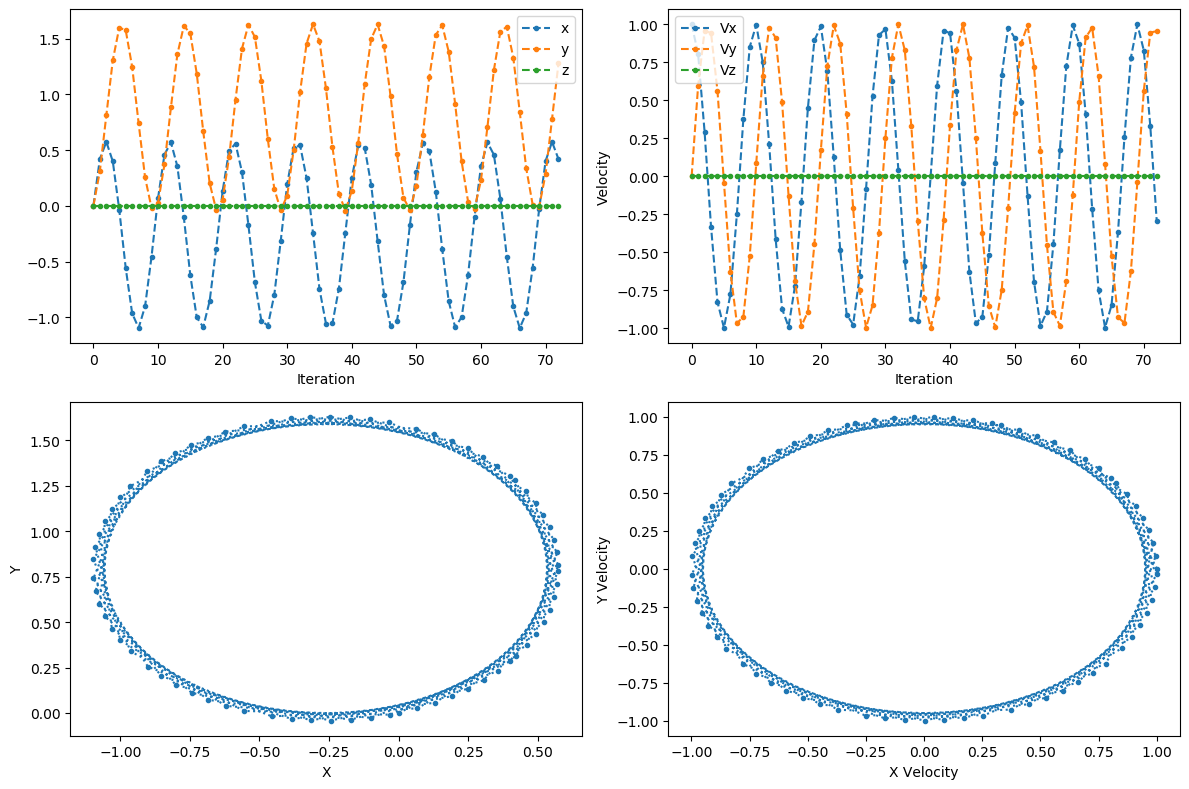

In [73]:
def drift(pusher, E=1, B=1):
    electric_field = np.array([E, 0, 0])
    magnetic_field = np.array([0, 0, B])
    
    # initial conditions
    u_t_minus_half = np.array([1, 0, 0])
    position = np.zeros(3)
    timestep = np.pi/6
    
    # I'm taking this a bit longer than the authors, so that the plots look nicer
    t = np.arange(0, 120/np.pi, timestep) 
    
    positions = []
    velocities = []
    for i in t:
        positions.append(position)
        velocities.append(u_t_minus_half)
        position, u_t_minus_half = pusher(position, u_t_minus_half, electric_field, magnetic_field, timestep)

    
    r = np.array(positions)
    v = np.array(velocities)
    return r, v

plot(*drift(BorisA, E=0, B=1));

That looks reasonable.

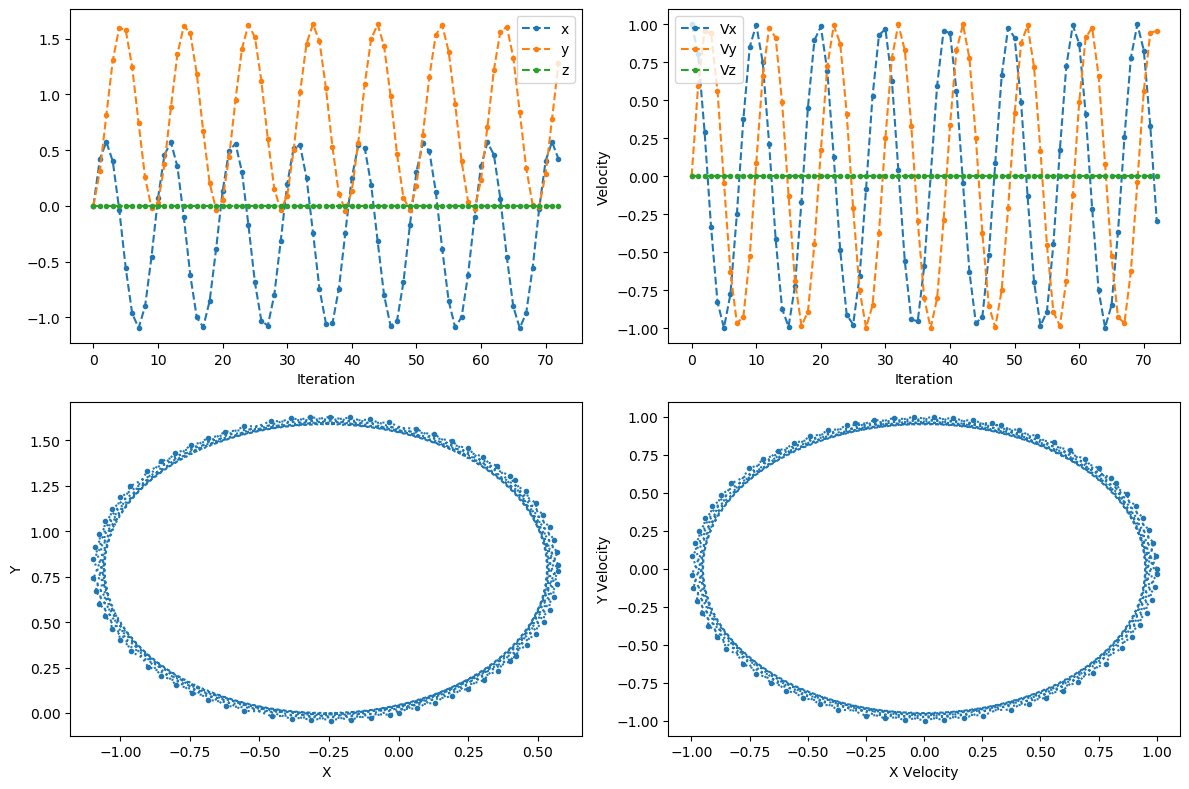

In [74]:
plot(*drift(BorisC, E=0, B=1));

Pretty indistinguishable from the BorisA case! In fact, that's what the authors claim and what we can check numerically:

In [75]:
for name, array_A, array_C in zip(["position", "velocity"], drift(BorisA), drift(BorisC)):
    print(f"BorisA and BorisC {'' if np.allclose(array_A, array_C, atol=1e-20, rtol=1e-15) else 'DO NOT '}agree on {name} for rotation.")

BorisA and BorisC DO NOT agree on position for rotation.
BorisA and BorisC DO NOT agree on velocity for rotation.


I went through the different cases presented for this part in the paper, and they seem to agree as well. Let's reproduce another example, the $\vec{E} \times \vec{B}$ drift. I won't show the BorisB plot here, as it doesn't visually differ, though the difference is there:

BorisA and BorisC DO NOT agree on position on the ExB drift.
BorisA and BorisC DO NOT agree on velocity on the ExB drift.


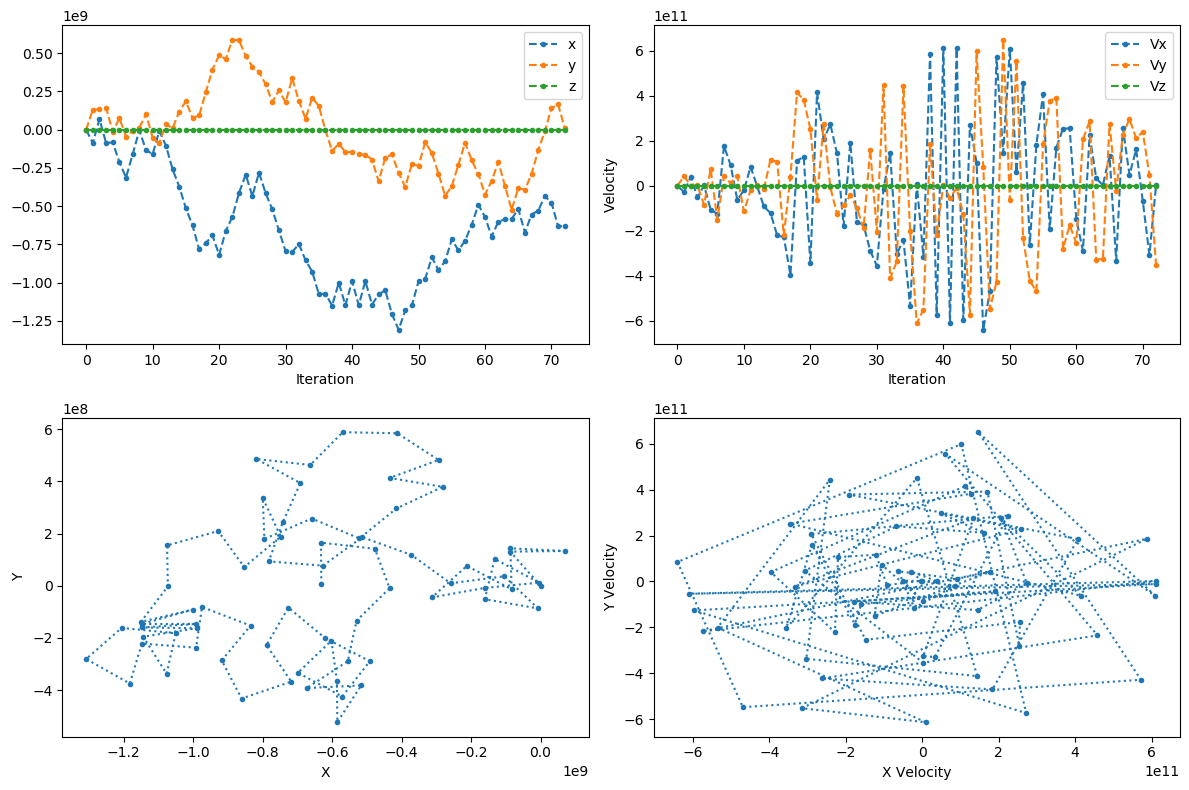

In [76]:
borisC_drift = plot(*drift(BorisC, E=1, B=1))
borisA_drift = drift(BorisA, E=1, B=1)
for name, array_A, array_C in zip(["position", "velocity"], borisA_drift, borisC_drift):
    print(f"BorisA and BorisC {'' if np.allclose(array_A, array_C, atol=1e-20, rtol=1e-15) else 'DO NOT '}agree on {name} on the ExB drift.")

# Long term stability tests

The authors define this as a long time run in the following fields:

$$ \phi = \frac{0.01}{\sqrt{x^2 + y^2)}} $$
$$ \vec{B} = \sqrt{x^2 + y^2} $$
with $\vec{E} = -\nabla \phi$ as usual. Let's just calculate the derivative with SymPy really quickly here:

In [77]:
from plasmapy.formulary import gyrofrequency

In [90]:
gyrofrequency?

Signature:
gyrofrequency(
    B: Unit("T"),
    particle='e-',
    signed=False,
    Z=None,
    to_hz=False,
) -> Unit("rad / s")
Docstring:
Calculate the particle gyrofrequency in units of radians per second.

Parameters
----------
B : ~astropy.units.Quantity
    The magnetic field magnitude in units convertible to tesla.

particle : str, optional
    Representation of the particle species (e.g., 'p' for protons, 'D+'
    for deuterium, or 'He-4 +1' for singly ionized helium-4),
    which defaults to electrons.  If no charge state information is
    provided, then the particles are assumed to be singly charged.

signed : bool, optional
    The gyrofrequency can be defined as signed (negative for electron,
    positive for ion). Default is `False` (unsigned, i.e. always
    positive).

Z : float or ~astropy.units.Quantity, optional
    The average ionization (arithmetic mean) for a plasma where the
    a macroscopic description is valid. If this quantity is not
    given then the atom

In [91]:
from sympy.abc import x, y
phi = 0.01 * (x**2 + y**2)**-0.5
phi

from sympy import lambdify

Ex = -phi.diff(x)
Ey = -phi.diff(y)
Ex = lambdify((x, y), Ex)
Ey = lambdify((x, y), Ey)

position = np.array([0.9, 0, 0])
x, y, z = position
magnetic_field = np.array([0, 0, np.sqrt(x**2 + y**2)])
electric_field = np.array([Ex(x, y), Ey(x, y), 0])

In [94]:
gyroperiod = 1 / gyrofrequency(np.linalg.norm(magnetic_field), to_hz = True)
gyroperiod

<Quantity 3.96931859e-11 1 / Hz>

In [97]:
dt = gyroperiod.si / 20
dt

<Quantity 1.98465929e-12 s>

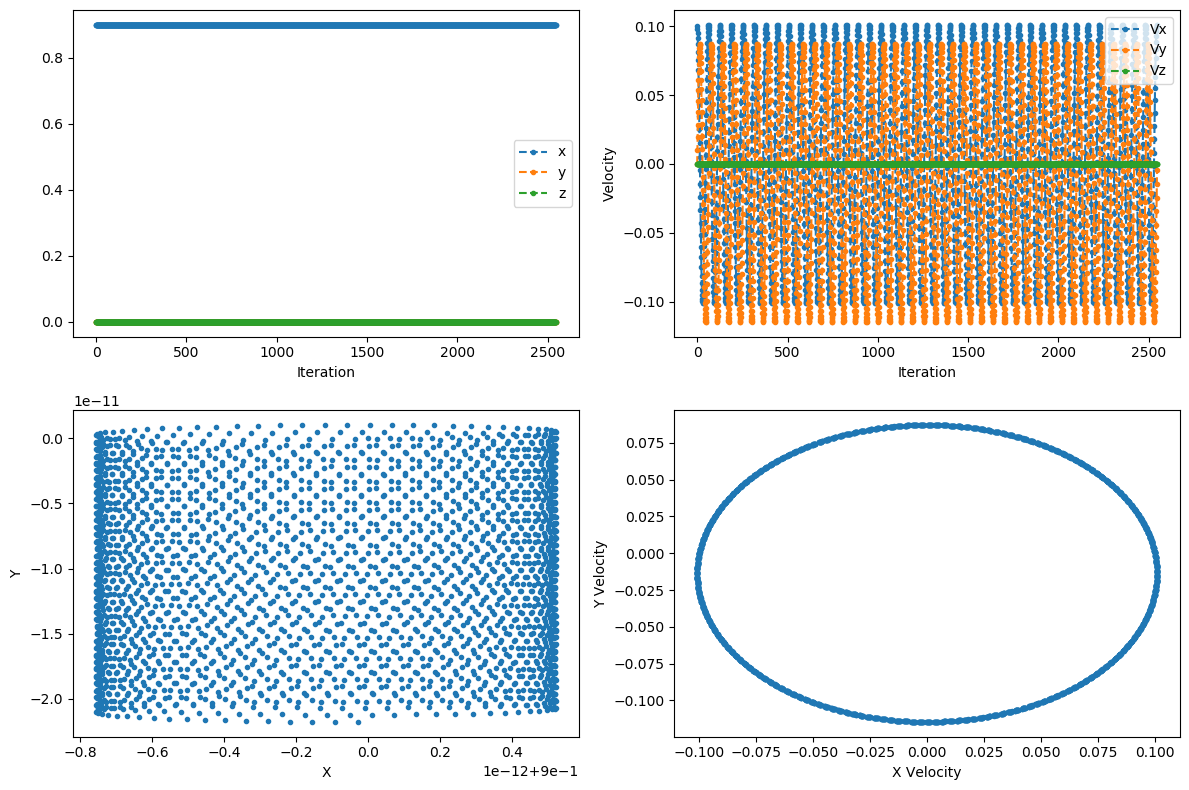

In [101]:
from sympy.abc import x, y
phi = 0.01 * (x**2 + y**2)**-0.5
phi

from sympy import lambdify

Ex = -phi.diff(x)
Ey = -phi.diff(y)
Ex = lambdify((x, y), Ex)
Ey = lambdify((x, y), Ey)

import tqdm.auto as tqdm
def stability(pusher, time_range=8e2):
    u_t_minus_half = np.array([0.1, 0, 0])
    position = np.array([0.9, 0, 0])
    timestep = np.pi/10 * dt.value
    t = np.arange(0, time_range * dt.value, timestep)    
    
    positions = []
    velocities = []
    for i in tqdm.tqdm(t):
        x, y, z = position
        magnetic_field = np.array([0, 0, np.sqrt(x**2 + y**2)])
        electric_field = np.array([Ex(x, y), Ey(x, y), 0])
        positions.append(position)
        velocities.append(u_t_minus_half)
        position, u_t_minus_half = pusher(position, u_t_minus_half, electric_field, magnetic_field, timestep)
    
    r = np.array(positions)
    v = np.array(velocities)
    return r, v
   

plot(*stability(BorisA), trajectory_format=".");

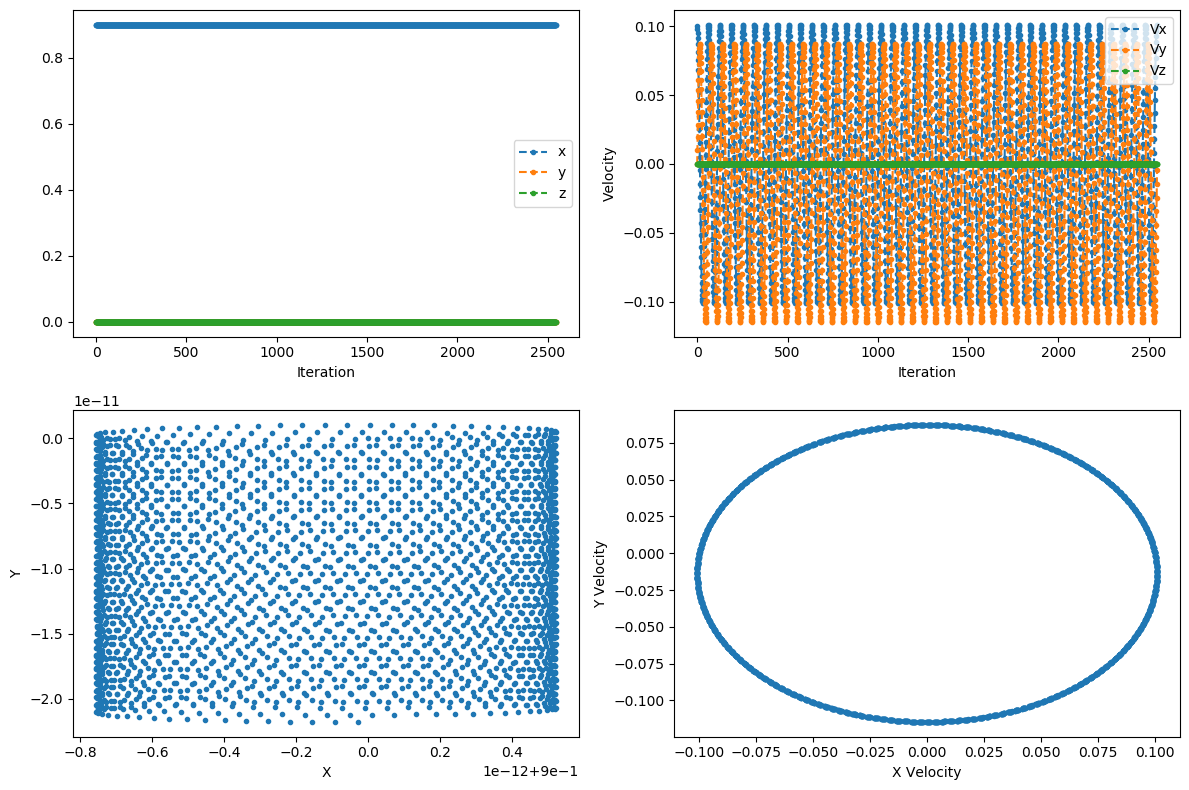

In [102]:
plot(*stability(BorisC), trajectory_format=".");

Note how the inner side of the velocity space trajectory becomes circular for the BorisB case and keeps making a neat pattern in the BorisA and BorisC cases!

In [103]:
rtol = 1e-9
for name, array_A, array_C in zip(["position", "velocity"], stability(BorisA), stability(BorisC)):
    print(f"BorisA and BorisC {'' if np.allclose(array_A, array_C, atol=1e-20, rtol=rtol) else 'DO NOT '}agree on {name} for long term stability for relative tolerance {rtol}.")


BorisA and BorisC agree on position for long term stability for relative tolerance 1e-09.
BorisA and BorisC agree on velocity for long term stability for relative tolerance 1e-09.


Do note that there does seem to be some long term error creeping in, as I had to lower `rtol`:

In [104]:
rtol = 1e-10
for name, array_A, array_C in zip(["position", "velocity"], stability(BorisA), stability(BorisC)):
    print(f"BorisA and BorisC {'' if np.allclose(array_A, array_C, atol=1e-20, rtol=rtol) else 'DO NOT '}agree on {name} for long term stability for relative tolerance {rtol}.")


BorisA and BorisC agree on position for long term stability for relative tolerance 1e-10.
BorisA and BorisC agree on velocity for long term stability for relative tolerance 1e-10.


In [105]:
rtol = 1e-15
for name, array_A, array_C in zip(["position", "velocity"], stability(BorisA), stability(BorisC)):
    print(f"BorisA and BorisC {'' if np.allclose(array_A, array_C, atol=1e-20, rtol=rtol) else 'DO NOT '}agree on {name} for long term stability for relative tolerance {rtol}.")


BorisA and BorisC agree on position for long term stability for relative tolerance 1e-15.
BorisA and BorisC DO NOT agree on velocity for long term stability for relative tolerance 1e-15.


Still, the results look all right, especially if we were to overlay the trajectories. Let's calculate a bunch of long-time trajectories (like the authors do) and make a quick adjustment to the plotting function:

In [106]:
borisA_stability = stability(BorisA, time_range=2e5)
borisC_stability = stability(BorisC, time_range=2e5)

def plot_shared(*tuples, r_format=",", v_format = ".", alpha=0.1, start_at):
    fig, axes = plt.subplots(ncols=2, figsize=(12, 7))
    for r, v in tuples:
        x, y, z = r[int(start_at):].T
        axes[0].set_title("x-y position trajectory")
        axes[0].plot(x, y, r_format, alpha=alpha)
        vx, vy, vz = v[int(start_at):].T
        
        axes[1].set_title("x-y velocity trajectory")
        axes[1].plot(vx, vy, v_format, alpha=alpha)
    plt.tight_layout()

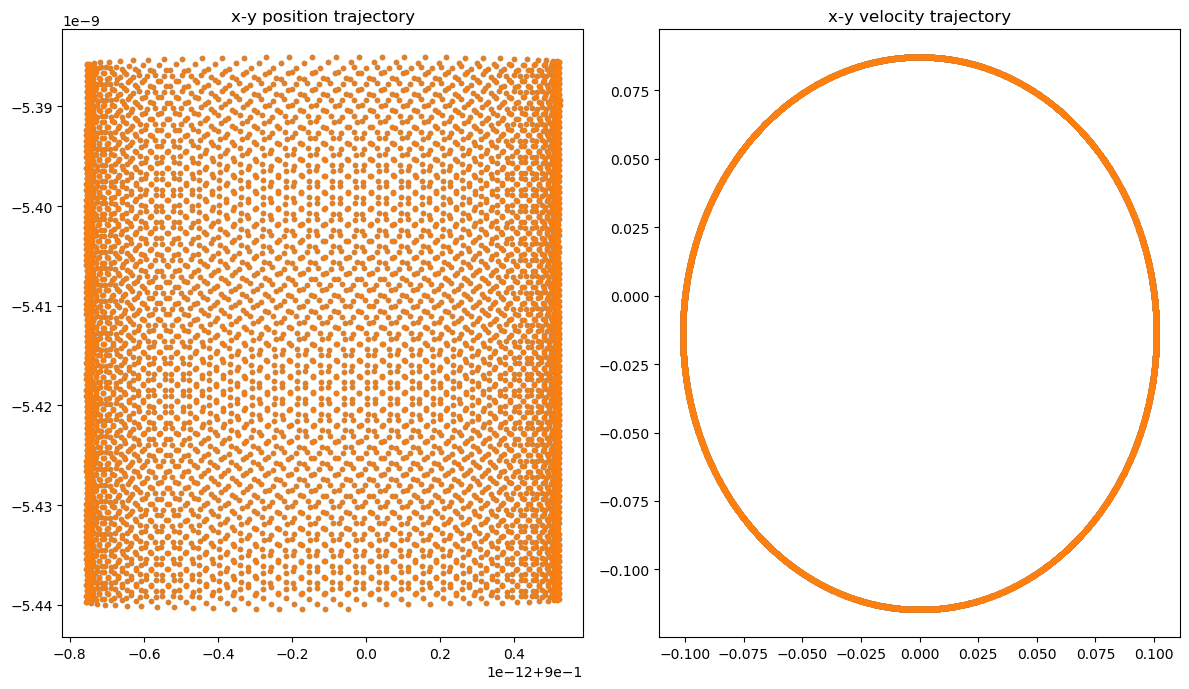

In [107]:
plot_shared(borisA_stability,
            borisC_stability,
            r_format=".",
            v_format=".",
            alpha=0.8,
            start_at = len(borisA_stability[0]) * 0.99
           )

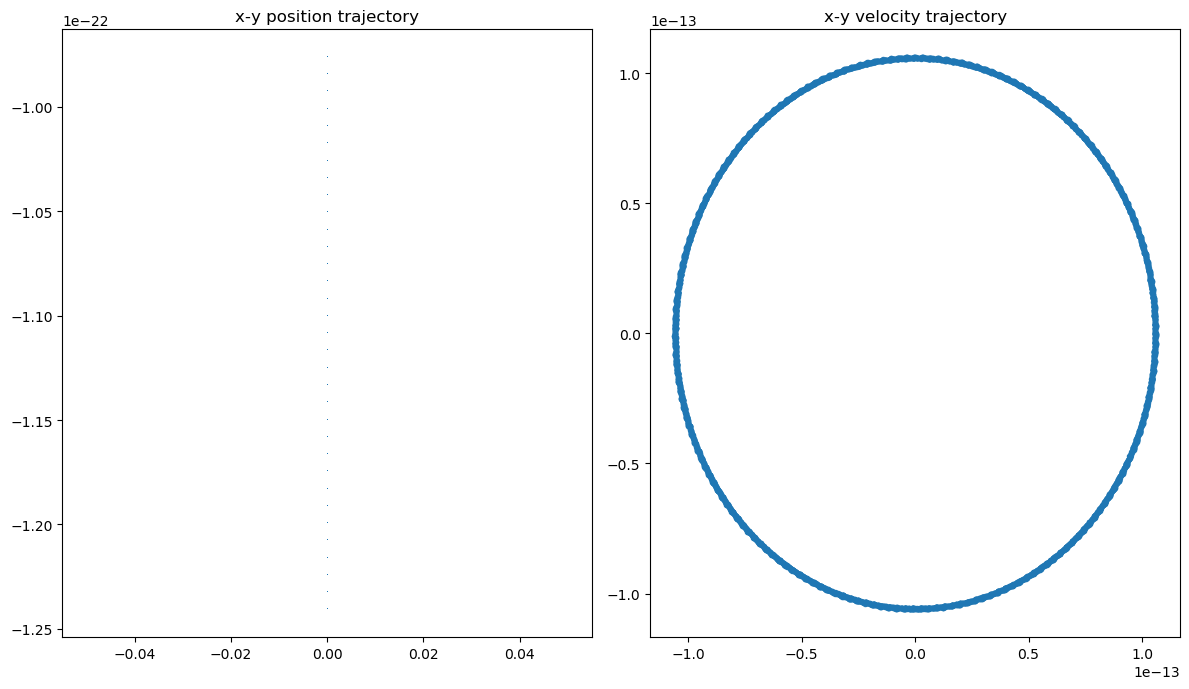

In [108]:
r_format=","
v_format = "."
alpha=0.8
start_at = len(borisA_stability[0]) * 0.99
r =  borisA_stability[0] - borisC_stability[0]
v =  borisA_stability[1] - borisC_stability[1]
x, y, z = r[int(start_at):].T
fig, axes = plt.subplots(ncols=2, figsize=(12, 7))
axes[0].set_title("x-y position trajectory")
axes[0].plot(x, y, r_format, alpha=alpha)
vx, vy, vz = v[int(start_at):].T

axes[1].set_title("x-y velocity trajectory")
axes[1].plot(vx, vy, v_format, alpha=alpha)
plt.tight_layout()

# Previous results

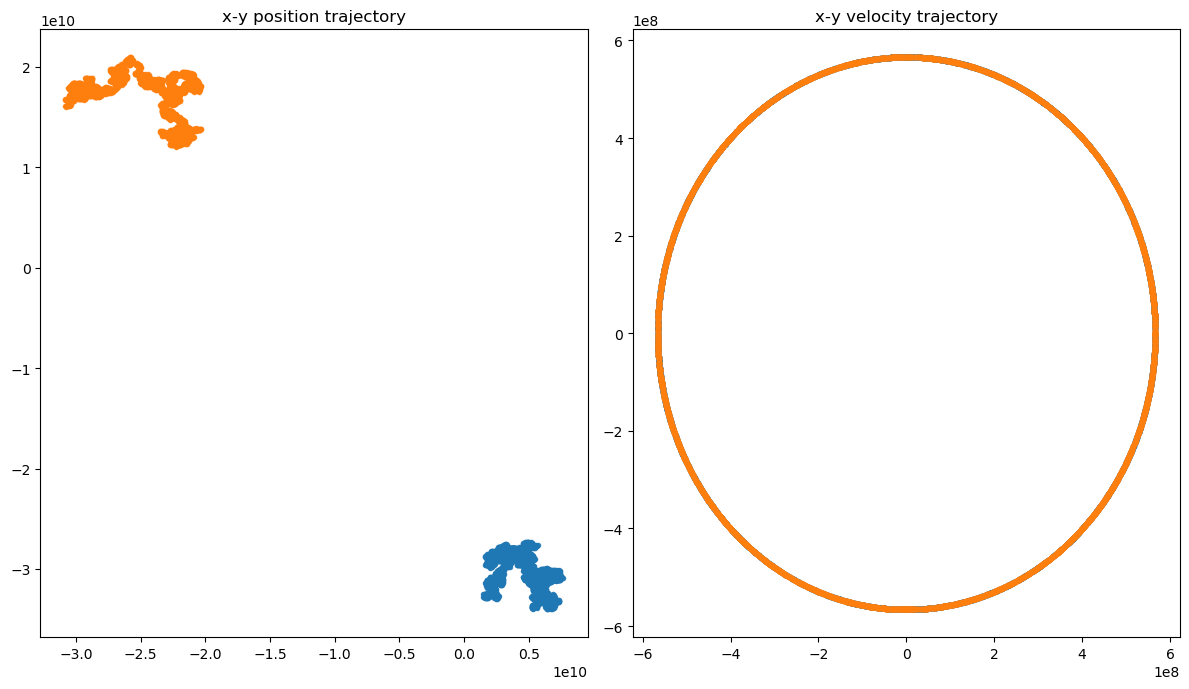

In [88]:
plot_shared(borisA_stability,
            borisC_stability,
            r_format=".",
            v_format=".",
            alpha=0.8,
            start_at = len(borisA_stability[0]) * 0.99
           )

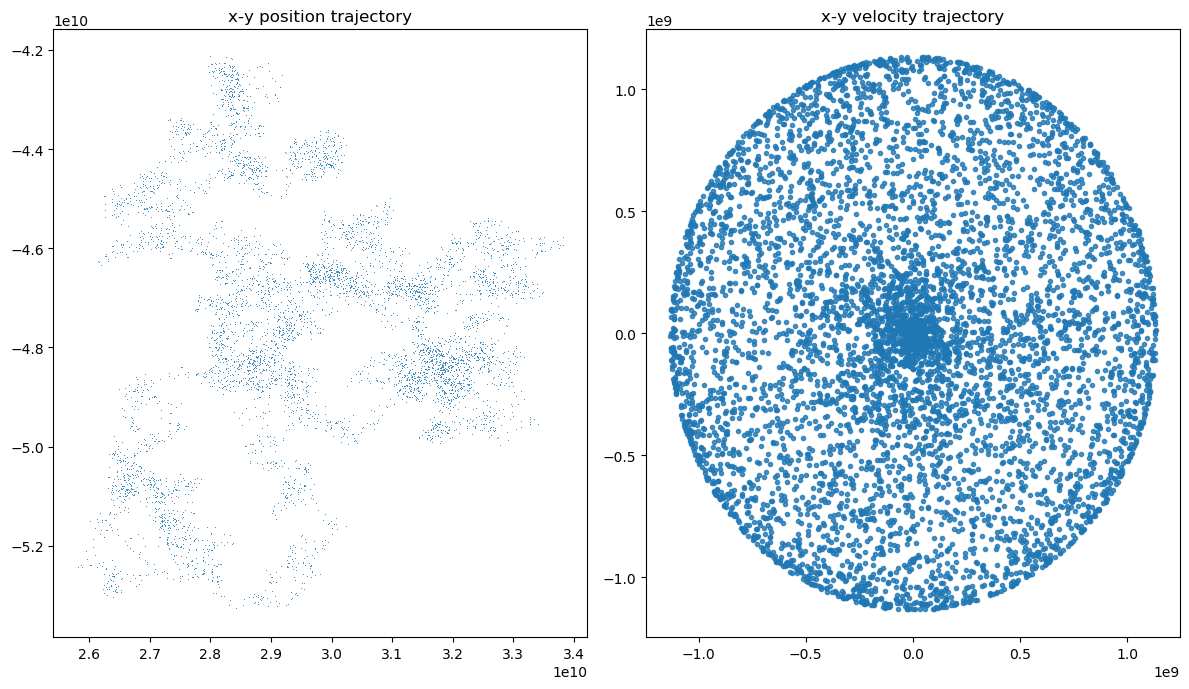

In [89]:
r_format=","
v_format = "."
alpha=0.8
start_at = len(borisA_stability[0]) * 0.99
r =  borisA_stability[0] - borisC_stability[0]
v =  borisA_stability[1] - borisC_stability[1]
x, y, z = r[int(start_at):].T
fig, axes = plt.subplots(ncols=2, figsize=(12, 7))
axes[0].set_title("x-y position trajectory")
axes[0].plot(x, y, r_format, alpha=alpha)
vx, vy, vz = v[int(start_at):].T

axes[1].set_title("x-y velocity trajectory")
axes[1].plot(vx, vy, v_format, alpha=alpha)
plt.tight_layout()